In [1]:
import os
import re
import datetime
import pandas as pd
import numpy as np
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely import box
import datashader as ds
from tqdm import tqdm
import seaborn as sns
from dotenv import load_dotenv
import dask.dataframe as dd
import dask.distributed
import dask_gateway
from dask.distributed import PipInstall, CondaInstall, WorkerPlugin, Client, get_worker
from dask import delayed
import folium
from folium.plugins import HeatMap

In [2]:
gateway = dask_gateway.Gateway()
cluster_options = gateway.cluster_options()
cluster = gateway.new_cluster(cluster_options)
cluster.adapt(minimum=1, maximum=100)
client = dask.distributed.Client(cluster)
client


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://planetarycomputer-hub.microsoft.com/services/dask-gateway/clusters/prod.bccd94a776104015bf2d6746c4fd81cd/status,


In [3]:
%load_ext dotenv
load_dotenv()
sas_token = os.environ['SAS_TOKEN']


folder_name = '202205_202209_drought'
pathname = 'abfs://ais/parquet/' + folder_name 

drought_ddf = dd.read_parquet(pathname, storage_options={"account_name": "rwsais", "sas_token": sas_token})


In [4]:
drought_ddf.columns
drought_ddf = drought_ddf[['sog','cog', 'rot','longitude', 'latitude', 'maneuver', 'seconds','name','draughtInland', 'length','width' ,'timestamplast']]

In [8]:

# Filter the DataFrame based on the conditions for length and width
filtered_drought_ddf = drought_ddf[(drought_ddf['length'] >= 110) & (drought_ddf['length'] <= 140) & 
                   (drought_ddf['width'] >= 9) & (drought_ddf['width'] <= 18)]

# Compute the number of unique 'name' instances in the filtered DataFrame
#unique_vessels_count = filtered_drought_ddf['name'].nunique().compute()

#print(f"Number of unique vessels with length between 110 and 140 and width between 9 and 18: {unique_vessels_count}")


In [13]:
# Filter on area
bounding_box = gpd.read_file('zoom_box_final.geojson')

polygon = bounding_box['geometry'].iloc[0]

def is_within_polygon(row):
    point = Point(row['longitude'], row['latitude'])
    return point.within(polygon)

def filter_within_polygon(partition, polygon):
    """Apply spatial filter to a partition of data."""
    # Convert the partition to a GeoDataFrame
    gdf = gpd.GeoDataFrame(partition, geometry=gpd.points_from_xy(partition.longitude, partition.latitude))
    
    # Perform spatial filtering
    gdf = gdf[gdf.geometry.within(polygon)]
    
    # Return the filtered partition without the geometry column if not needed
    return gdf.drop(columns=['geometry'])

# Assuming `filtered_drought_ddf` is a Dask DataFrame
if isinstance(filtered_drought_ddf, dd.DataFrame):
    # Use map_partitions to apply the spatial filter
    ddf = filtered_drought_ddf.map_partitions(filter_within_polygon, polygon=polygon, meta=filtered_drought_ddf)
else:
    # If it's not a Dask DataFrame, assuming it's a regular DataFrame or GeoDataFrame
    gdf = gpd.GeoDataFrame(filtered_drought_ddf, geometry=gpd.points_from_xy(filtered_drought_ddf.longitude, filtered_drought_ddf.latitude))
    ddf = gdf[gdf.geometry.within(polygon)].drop(columns=['geometry'])

In [14]:
# convert timestamplast string to convenient datetime type
ddf['datetime'] = dd.to_datetime(ddf['timestamplast'])
ddf = ddf.drop(columns='timestamplast')

In [15]:
df = ddf.compute()

In [16]:
import pandas as pd

def trajectory_splitter(df):
    "Function that takes AIS df and splits it into trajectories"
    
    # Convert 'datetime' column to pandas datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Sort the dataframe by vessel name and datetime
    df = df.sort_values(by=['name', 'datetime']).reset_index(drop=True)
    
    # Calculate the time difference between consecutive rows
    df['time_diff'] = df.groupby('name')['datetime'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds()
    
    # Calculate whether each row is the start of a new trajectory
    df['prev_name'] = df['name'].shift(1).fillna(df['name'])
    df['new_trajectory'] = ((df['time_diff'] > 30) | (df['name'] != df['prev_name'])).astype(int)
    
    # Calculate cumulative sum of new_trajectory to get trajectory_id
    df['traj_id'] = df['new_trajectory'].cumsum() - 1
    
    # Drop the helper columns
    df = df.drop(columns=['new_trajectory', 'prev_name'])
    
    return df

# Example usage
df_traj = trajectory_splitter(df)


In [17]:
# count the mean number of rows every trajectory has
mean_rows_per_trajectory = df_traj.groupby('traj_id').size().mean()
print(f"Mean number of rows per trajectory: {mean_rows_per_trajectory:.2f}")


Mean number of rows per trajectory: 42.50


In [18]:
# count how many rows there are part of trajectories that have less than 5 rows
short_trajectories = df_traj.groupby('traj_id').size()
short_trajectories = short_trajectories[short_trajectories < 5]
short_trajectories_count = short_trajectories.sum()
print(f"Number of rows that are part of trajectories with less than 5 rows: {short_trajectories_count}")
# remove rows
df_traj = df_traj[~df_traj['traj_id'].isin(short_trajectories.index)]

Number of rows that are part of trajectories with less than 5 rows: 44552


In [19]:
43819 / len(df)

0.017956097119214077

In [20]:
# Calculate speed based on the distance between two consecutive points and the time difference using haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371000  # Radius of Earth in meters. Use 3956 for miles
    return c * r


def calculate_velocity_acceleration(df):
    # Sort the data
    df = df.sort_values(by=['name', 'traj_id', 'datetime'])
    
    # Calculate distance using the Haversine formula
    df['distance'] = haversine(df['latitude'].shift(), df['longitude'].shift(), df['latitude'], df['longitude'])
    
    # Calculate time difference in seconds
    df['time_diff'] = df['datetime'].diff().dt.total_seconds() 
    
    # Calculate speed in km/h
    df['speed'] = (df['distance'] / df['time_diff']) * 3.6
    
    
    # Calculate acceleration in km/h/s
    df['acceleration_kmh_s'] = df['speed'].diff() / df['time_diff']

    # Convert acceleration to m/s^2
    df['acceleration'] = df['acceleration_kmh_s'] * (5/18)

    # Correct calculations across different trajectories
    mask = df['traj_id'] != df['traj_id'].shift()
    df.loc[mask, 'distance'] = np.nan
    df.loc[mask, 'speed'] = np.nan
    df.loc[mask, 'acceleration'] = np.nan

    return df.drop(columns=['acceleration_kmh_s'])

df_with_calculations = calculate_velocity_acceleration(df_traj)


In [21]:
# count how manu inf values there are in the acceleration and speed column
inf_values_speed = df_with_calculations['speed'].isnull().sum()
inf_values_acceleration = df_with_calculations['acceleration'].isnull().sum()
print(f"Number of inf values in the speed column: {inf_values_speed}")
print(f"Number of inf values in the acceleration column: {inf_values_acceleration}")

# count how many nan values there are in the acceleration and speed column
nan_values_speed = df_with_calculations['speed'].isna().sum()
nan_values_acceleration = df_with_calculations['acceleration'].isna().sum()
print(f"Number of nan values in the speed column: {nan_values_speed}")
print(f"Number of nan values in the acceleration column: {nan_values_acceleration}")

# remove rows with inf values in the speed and acceleration columns
df_with_calculations = df_with_calculations[~df_with_calculations['speed'].isnull()]
df_with_calculations = df_with_calculations[~df_with_calculations['acceleration'].isnull()]

# remove rows with nan values in the speed and acceleration columns
df_with_calculations = df_with_calculations[~df_with_calculations['speed'].isna()]
df_with_calculations = df_with_calculations[~df_with_calculations['acceleration'].isna()]


Number of inf values in the speed column: 17804
Number of inf values in the acceleration column: 19111
Number of nan values in the speed column: 17804
Number of nan values in the acceleration column: 19111


In [22]:
# remove 1 percent of outliers in the speed and acceleration columns
speed_q99 = df_with_calculations['speed'].quantile(0.99)
acceleration_q1 = df_with_calculations['acceleration'].quantile(0.01)
acceleration_q99 = df_with_calculations['acceleration'].quantile(0.99)

print(len(df_with_calculations))
df_with_calculations = df_with_calculations[df_with_calculations['speed'] < speed_q99]
df_with_calculations = df_with_calculations[(df_with_calculations['acceleration'] > acceleration_q1) & (df_with_calculations['acceleration'] < acceleration_q99)]
print(len(df_with_calculations))


2376678
2318581


In [23]:
df_with_calculations['acceleration'].describe()

count    2.318581e+06
mean     6.631912e-03
std      1.381685e-01
min     -9.433971e-01
25%     -4.550459e-02
50%     -1.287348e-04
75%      4.836917e-02
max      1.079570e+00
Name: acceleration, dtype: float64

In [24]:
ddf_with_calculations = dd.from_pandas(df_with_calculations, npartitions=100)
ddf_with_calculations.columns

Index(['sog', 'cog', 'rot', 'longitude', 'latitude', 'maneuver', 'seconds',
       'name', 'draughtInland', 'length', 'width', 'datetime', 'time_diff',
       'traj_id', 'distance', 'speed', 'acceleration'],
      dtype='object')

In [ ]:

folder_name = '202205_202209_drought_velocity_profiles'
pathname = 'abfs://ais/parquet/' + folder_name 
sas_token2 = os.environ['SAS_TOKEN2']


dd.to_parquet(ddf_with_calculations,
              engine='pyarrow',
              write_index = False,
              path=pathname,
              write_metadata_file=False,
              storage_options={'account_name': 'rwsais',
                               'account_key': sas_token2})

### Exploratory Plots

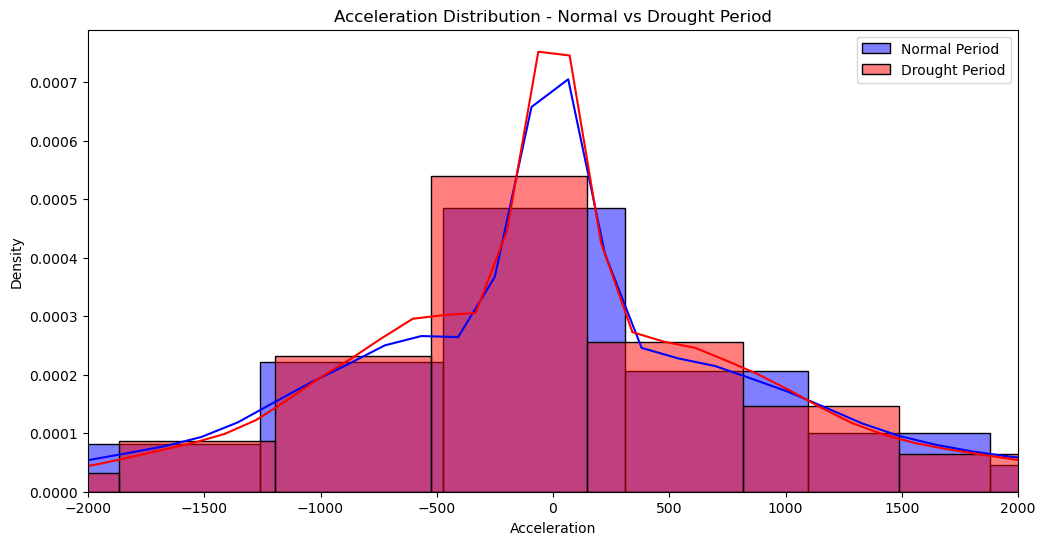

In [160]:

# Assuming 'normal_period' and 'drought_period' are defined and contain the appropriate dataframes

plt.figure(figsize=(12, 6))

# Plot histogram for normal period
sns.histplot(normal_df['acceleration'], color='blue', kde=True, label='Normal Period', stat="density", bins=40)

# Plot histogram for drought period
sns.histplot(drought_df['acceleration'], color='red', kde=True, label='Drought Period', stat="density", bins=40)

plt.title('Acceleration Distribution - Normal vs Drought Period')
plt.xlabel('Acceleration')
plt.ylabel('Density')
plt.legend()
plt.xlim(-2000, 2000) 
plt.show()


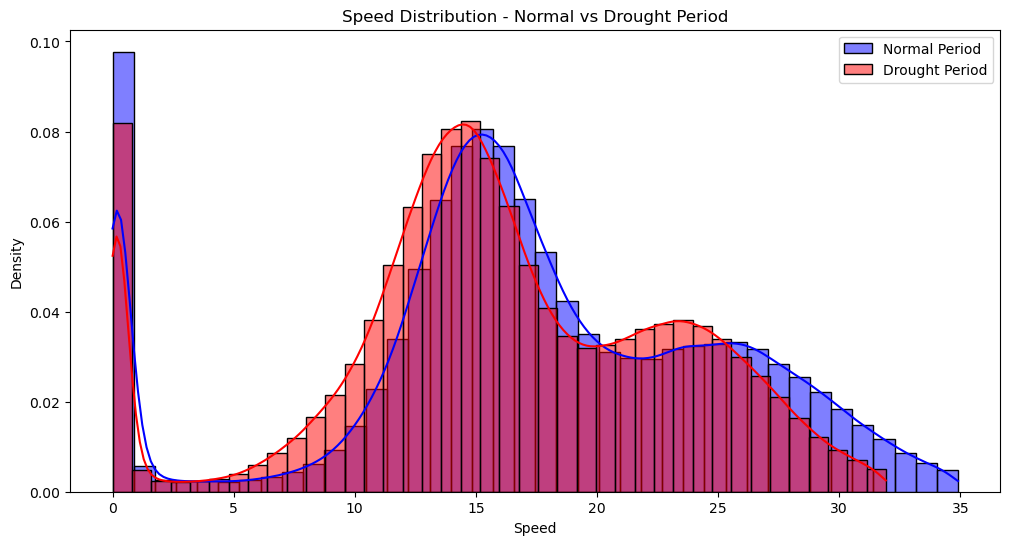

In [161]:
import seaborn as sns

# Assuming 'normal_period' and 'drought_period' are defined and contain the appropriate dataframes

plt.figure(figsize=(12, 6))

# Plot histogram for normal period
sns.histplot(normal_df['speed'], color='blue', kde=True, label='Normal Period', stat="density", bins=40)

# Plot histogram for drought period
sns.histplot(drought_df['speed'], color='red', kde=True, label='Drought Period', stat="density", bins=40)

plt.title('Speed Distribution - Normal vs Drought Period')
plt.xlabel('Speed')
plt.ylabel('Density')
plt.legend()
#plt.xlim(-2000, 2000) 
plt.show()


### Angular Difference (not used directly)

In [35]:
# Function to calculate angular differences
def angular_difference(cogs):
    diff = np.diff(cogs)
    # Normalize differences to be within [-180, 180]
    diff = (diff + 180) % 360 - 180
    return np.abs(diff)

# Apply the angular difference calculation within each trajectory
df_traj['angular_difference'] = np.nan

# Group by trajectory_id and calculate angular differences
for trajectory_id, group in df_traj.groupby('trajectory_id'):
    if len(group) > 1:
        angular_diff = angular_difference(group['cog'].values)
        df_traj.loc[group.index[1:], 'angular_difference'] = angular_diff

In [39]:
gdf = gpd.GeoDataFrame(df_traj, geometry=gpd.points_from_xy(df_traj.longitude, df_traj.latitude))


In [72]:
gdf[gdf['trajectory_id'] == 800]

,sog,cog,rot,longitude,latitude,maneuver,seconds,name,draughtInland,length,width,datetime,trajectory_id,angular_difference,geometry
121422,5.9,129.800003,0.0,5.834995,51.861061,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:33:20+00:00,800.0,NaN,POINT (5.83499 51.86106)
121423,5.9,130.600006,0.0,5.835332,51.860886,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:33:31+00:00,800.0,0.800003,POINT (5.83533 51.86089)
121424,5.8,131.399994,0.0,5.835627,51.860722,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:33:40+00:00,800.0,0.799988,POINT (5.83563 51.86072)
121425,5.8,130.500000,0.0,5.836022,51.860508,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:33:51+00:00,800.0,0.899994,POINT (5.83602 51.86051)
121426,5.8,131.399994,0.0,5.836315,51.860348,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:34:00+00:00,800.0,0.899994,POINT (5.83632 51.86035)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121552,6.0,19.900000,0.0,5.879187,51.855362,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:55:11+00:00,800.0,2.200001,POINT (5.87919 51.85536)
121553,6.1,20.500000,0.0,5.879342,51.855625,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:55:21+00:00,800.0,0.600000,POINT (5.87934 51.85563)
121554,6.1,21.000000,0.0,5.879490,51.855862,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:55:30+00:00,800.0,0.500000,POINT (5.87949 51.85586)
121555,6.2,20.200001,0.0,5.879650,51.856129,1,60.0,testschip-1184,1.65,110.0,11.0,2022-08-16 20:55:40+00:00,800.0,0.799999,POINT (5.87965 51.85613)


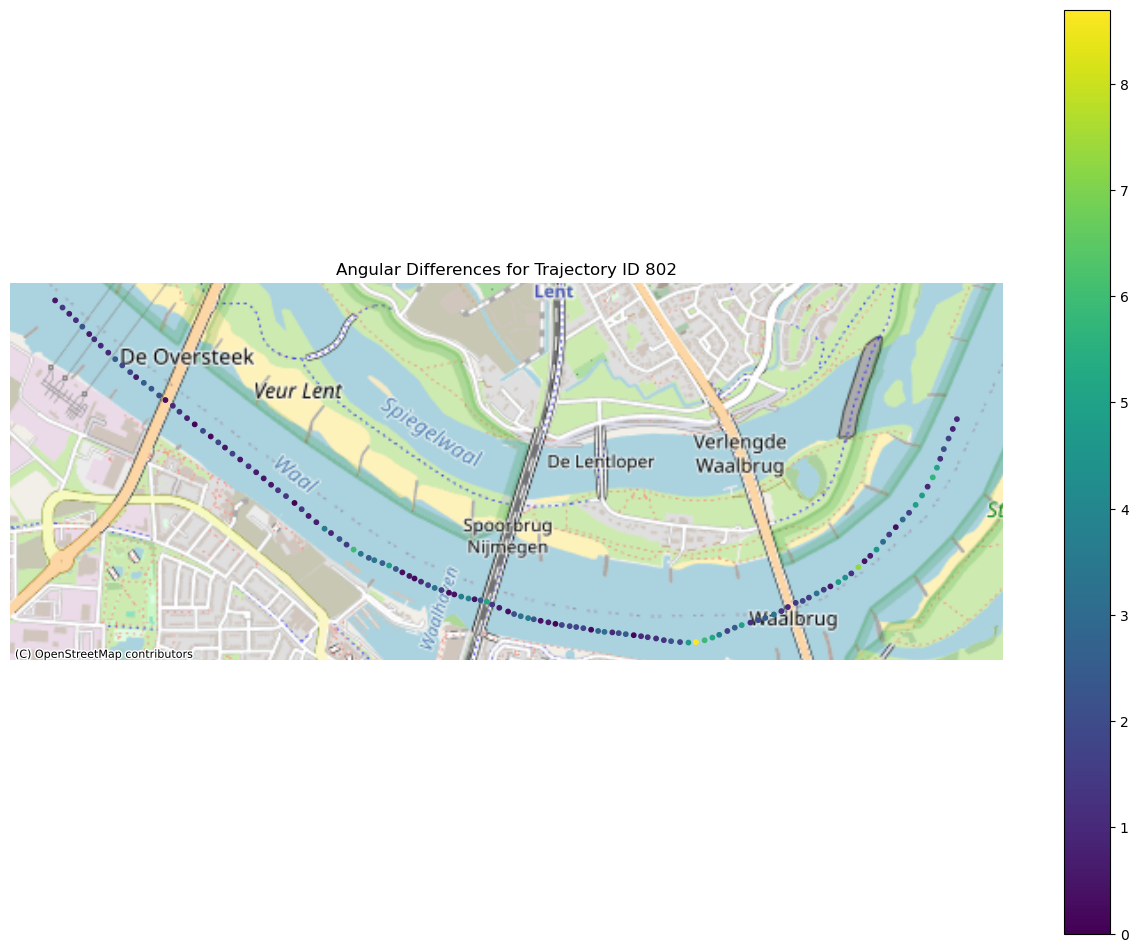

In [80]:
import contextily as ctx

# Filter the GeoDataFrame for the first trajectory (replace '8' with the trajectory_id you want to plot)
gdf.set_crs(epsg=4326, inplace=True)  # WGS84 CRS

vessels_per_day = df['name'].resample('D').nunique()
vessels_per_day.plot(kind='line', figsize=(15, 5), title='Vessels per day')gdf = gdf.to_crs(epsg=3857) 

trajectory_id_to_plot = 802
gdf_filtered = gdf[gdf['trajectory_id'] == trajectory_id_to_plot]

# Plotting the angular difference of the first trajectory spatially on OpenStreetMap
fig, ax = plt.subplots(figsize=(16, 12))  # Increase the figure size

# Plot the GeoDataFrame on the axis
gdf_filtered.plot(ax=ax, column='angular_difference', cmap='viridis', markersize=10, legend=True)

# Add OpenStreetMap tiles
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Adjust plot parameters
ax.set_title('Angular Differences for Trajectory ID {}'.format(trajectory_id_to_plot))
ax.set_axis_off()

plt.show()